In [3]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

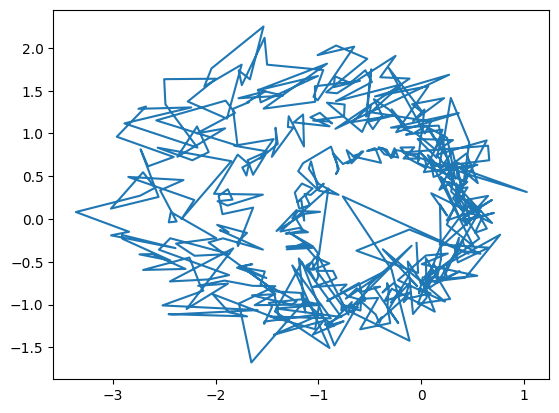

In [52]:
data = pd.read_csv("data_spin.tsv", sep="\t")
accs_x = jnp.array(data["Linear Acceleration x (m/s^2)"])
accs_y = jnp.array(data["Linear Acceleration y (m/s^2)"])
accs_z = jnp.array(data["Linear Acceleration z (m/s^2)"])

accs_xy = jnp.stack((accs_x, accs_y), axis=1)

plt.plot(accs_xy[:, 0], accs_xy[:, 1]);

In [76]:
def model(acc_obs, start=None):
    def random_walk(start, steps, step_scale=1.0):
        poss = [start]
        for i in range(steps):
            poss.append(numpyro.sample(f"step_{i}", dist.Normal(poss[-1], step_scale)))
        return jnp.array(poss)

    steps = len(acc_obs) + 2

    if start is None:
        start = numpyro.sample("start", dist.Normal(jnp.array([0.0, 0.0]), 100.0))

    poss = numpyro.deterministic("poss", random_walk(start, steps - 1))

    # There must be neater numpy functions for this
    vels = jnp.array([x_ - x for x, x_ in zip(poss, poss[1:])])
    accs = jnp.array([v_ - v for v, v_ in zip(vels, vels[1:])])

    # Do this with plate instead?
    for i, (a, o) in enumerate(zip(accs, acc_obs)):
        numpyro.sample(f"obs{i}", dist.Normal(a, 1.0), obs=o)

In [91]:
key = jr.key(1729)

mcmc = MCMC(NUTS(model), num_warmup=100, num_samples=100)
mcmc.run(key, acc_obs=accs_xy[:10])
samples = mcmc.get_samples()

sample: 100%|██████████| 200/200 [00:05<00:00, 37.47it/s, 47 steps of size 3.87e-03. acc. prob=0.77]  


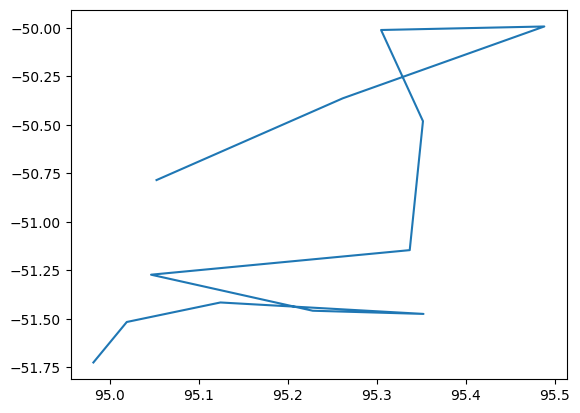

In [92]:
mposs = jnp.mean(samples["poss"], axis=0)

plt.plot(mposs[:,0], mposs[:,1]);